In [1]:
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from model import *
from tqdm import tqdm
import glob
import cv2
import matplotlib.pyplot as plt
import numpy as np

# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/users/nfs/Enseignants/piwowarski/venv/deepdac/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
2023-11-22 02:08:34.180394: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-22 02:08:34.297510: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-22 02:08:36.158750: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: 

In [12]:
dataPath = 'cats'
data_cats = glob.glob(dataPath+'/*.jpg')

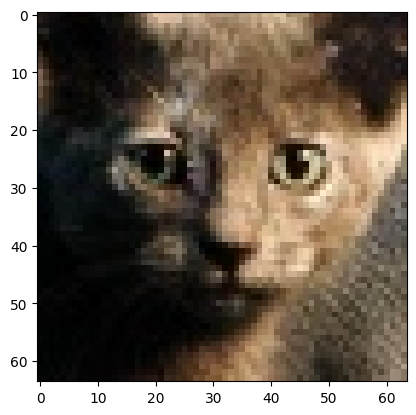

In [13]:
img = cv2.imread(data_cats[0])
plt.imshow(img)

In [21]:
class CatDataset(Dataset):
    def __init__(self, data_path, transform):
        self.transform = transform
        self.data_path = data_path

    def __len__(self):
        return len(self.data_path)
    
    def __getitem__(self, idx):
        sample = cv2.imread(self.data_path[idx])
        sample = self.transform(sample)
        return sample

We do not need to resize since the image are already at size 64x64, or we could do center-crop + resize for experiments

In [24]:
BATCH_SIZE = 128
# transform config
cat_transforms = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)
# dataset
catDS = CatDataset(data_cats, cat_transforms)
print("Data size: ", len(catDS))
# dataloader
dataloader = DataLoader(catDS, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)

Data size:  15747


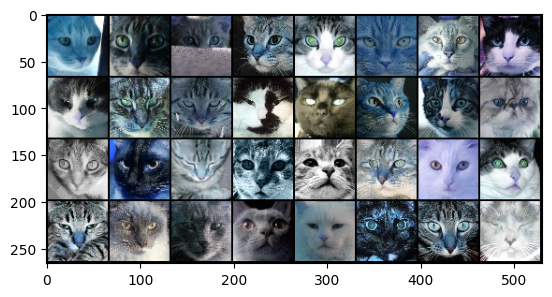

In [25]:
for data in dataloader:
    img = torchvision.utils.make_grid(data[:32], normalize=True)
    plt.imshow(img.cpu().permute(1, 2, 0))
    plt.show()
    break

In [26]:
LEARNING_RATE = 0.0002
IMG_DIM = 3
NOISE_SIZE = 100
FEATURES_DISCRIMINATOR = 64
FEATURES_GENERATOR = 64
# networks
generator = Generator(NOISE_SIZE, IMG_DIM, FEATURES_GENERATOR).to(device)
discriminator = Discriminator(IMG_DIM, FEATURES_DISCRIMINATOR).to(device)
# init weights
init_weights(generator)
init_weights(discriminator)
# optim
opt_generator = torch.optim.Adam(generator.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
opt_discriminator = torch.optim.Adam(discriminator.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
# loss_fn
criterion = torch.nn.BCELoss()

In [27]:
%load_ext tensorboard
%tensorboard --logdir runs

Reusing TensorBoard on port 6006 (pid 56054), started 1:14:22 ago. (Use '!kill 56054' to kill it.)

  4%|█▉                                         | 9/200 [02:10<46:14, 14.53s/it]

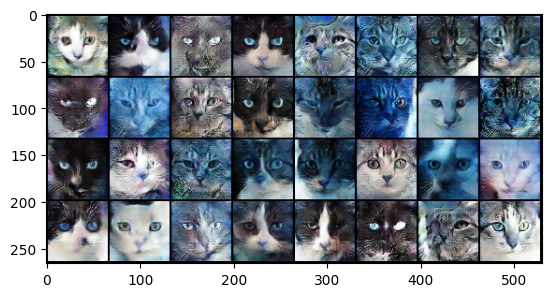

 10%|███▉                                      | 19/200 [04:35<44:01, 14.59s/it]

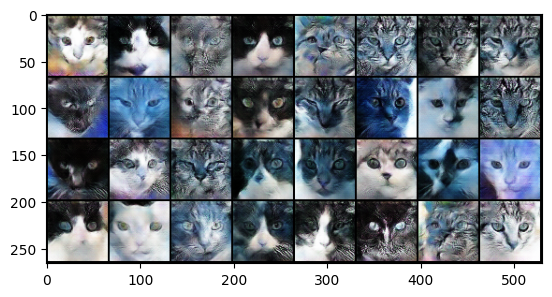

 14%|██████                                    | 29/200 [07:01<41:32, 14.58s/it]

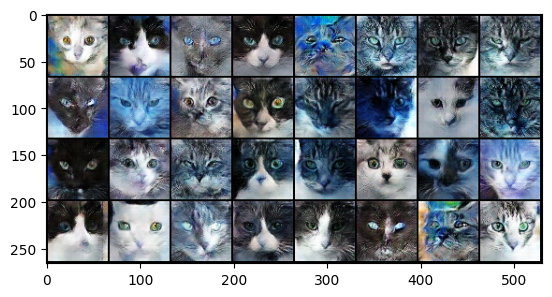

 20%|████████▏                                 | 39/200 [09:27<39:01, 14.55s/it]

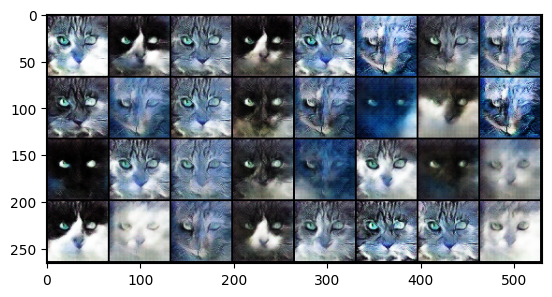

 24%|██████████▎                               | 49/200 [11:52<36:36, 14.54s/it]

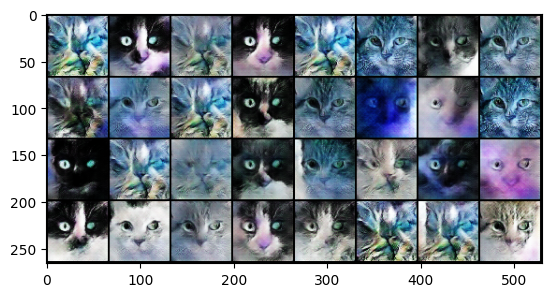

 30%|████████████▍                             | 59/200 [14:17<34:03, 14.49s/it]

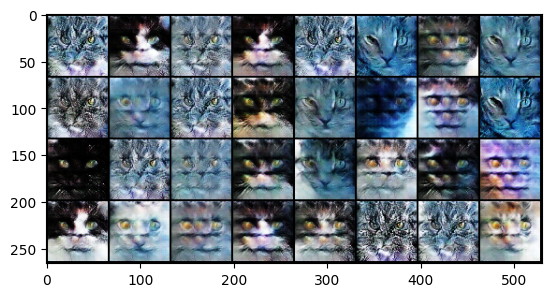

 34%|██████████████▍                           | 69/200 [16:43<31:46, 14.55s/it]

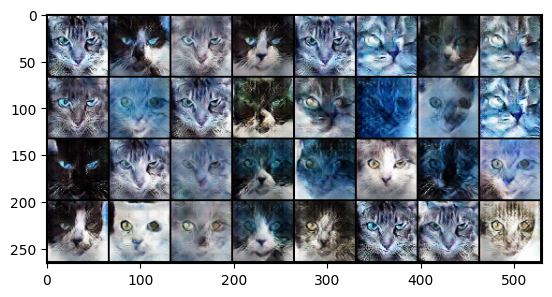

 40%|████████████████▌                         | 79/200 [19:09<29:15, 14.51s/it]

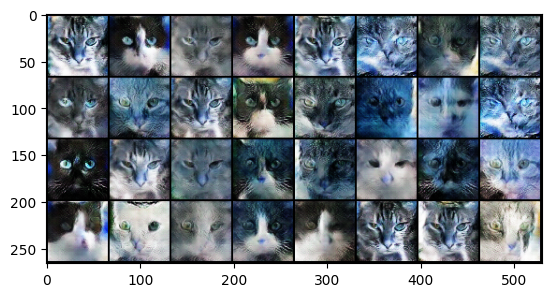

 44%|██████████████████▋                       | 89/200 [21:34<26:53, 14.53s/it]

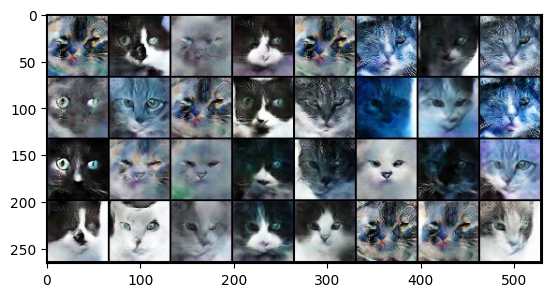

 50%|████████████████████▊                     | 99/200 [23:59<24:23, 14.49s/it]

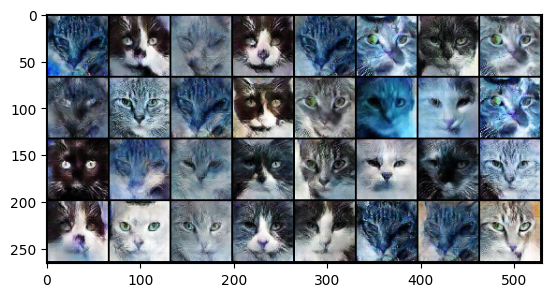

 55%|██████████████████████▎                  | 109/200 [26:25<22:05, 14.56s/it]

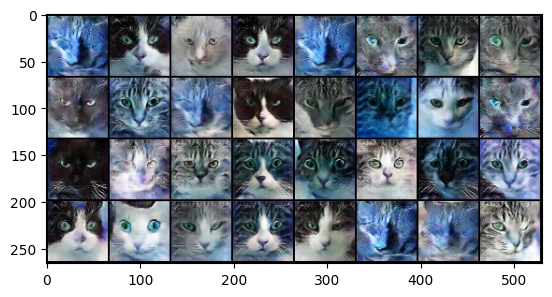

 60%|████████████████████████▍                | 119/200 [28:51<19:36, 14.52s/it]

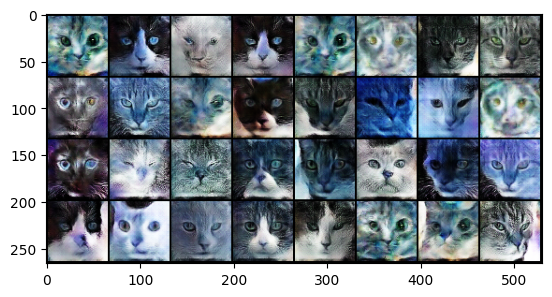

 64%|██████████████████████████▍              | 129/200 [31:16<17:10, 14.52s/it]

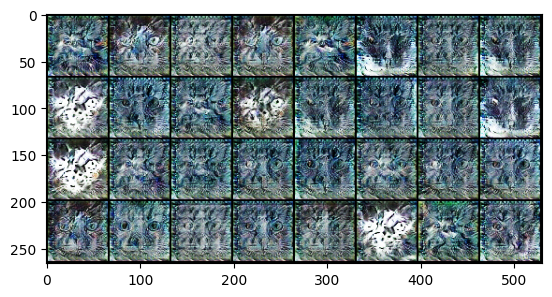

 70%|████████████████████████████▍            | 139/200 [33:42<14:45, 14.51s/it]

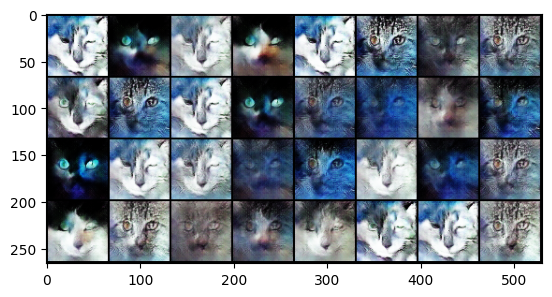

 74%|██████████████████████████████▌          | 149/200 [36:07<12:20, 14.53s/it]

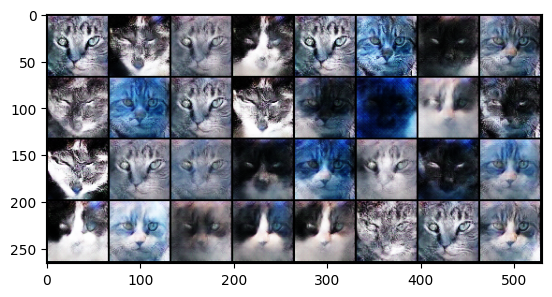

 80%|████████████████████████████████▌        | 159/200 [38:33<09:54, 14.49s/it]

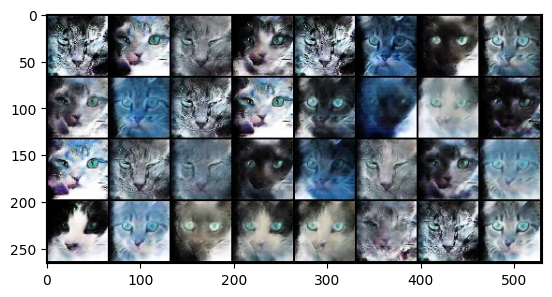

 84%|██████████████████████████████████▋      | 169/200 [40:58<07:32, 14.59s/it]

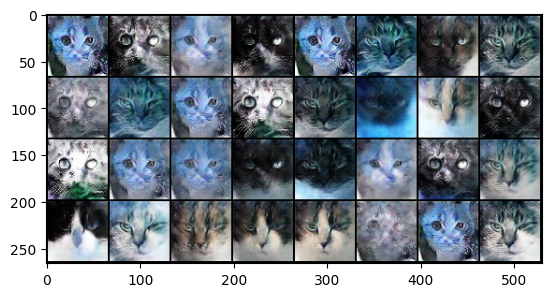

 90%|████████████████████████████████████▋    | 179/200 [43:23<05:04, 14.48s/it]

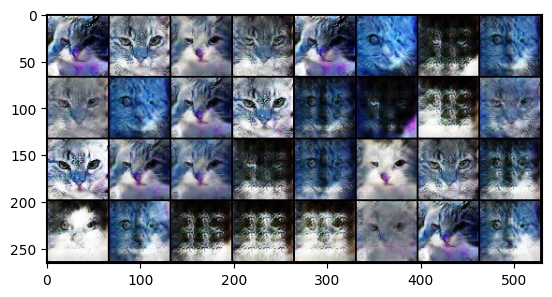

 94%|██████████████████████████████████████▋  | 189/200 [45:49<02:39, 14.51s/it]

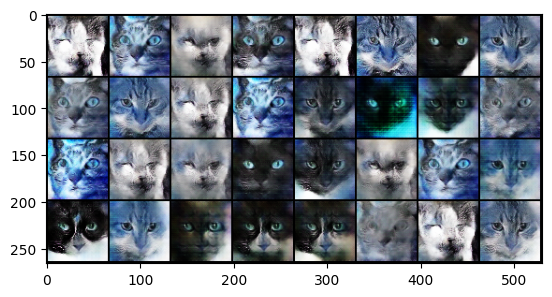

100%|████████████████████████████████████████▊| 199/200 [48:14<00:14, 14.49s/it]

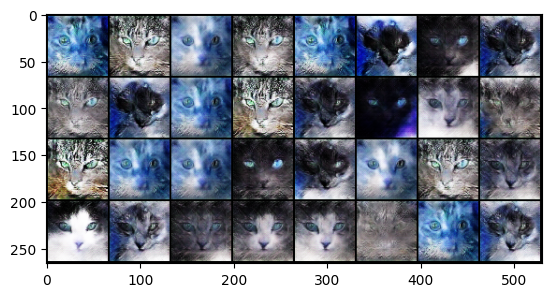

100%|█████████████████████████████████████████| 200/200 [48:29<00:00, 14.55s/it]


In [31]:
EPOCHS = 200
NB_TEST_VIEW = 32
fixed_noise = torch.randn(NB_TEST_VIEW, NOISE_SIZE, 1, 1).to(device)
writer = SummaryWriter()

generator.train()
discriminator.train()

for epoch in tqdm(range(EPOCHS)):
    loss_generator = 0.
    loss_discriminator = 0.
    for batch_idx, data in enumerate(dataloader):
        real = data.to(device)
        noise = torch.randn(BATCH_SIZE, NOISE_SIZE, 1, 1).to(device)
        fake = generator(noise)

        ### Train Discriminator
        # real images labels are 1
        disc_real = discriminator(real).reshape(-1)
        loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))
        # fake images labels are 0
        disc_fake = discriminator(fake.detach()).reshape(-1)
        loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        # loss is mean of these 2 losses
        loss_disc = (loss_disc_real + loss_disc_fake) / 2
        discriminator.zero_grad()
        loss_disc.backward()
        opt_discriminator.step()

        ### Train Generator
        # for generator, in order to fool the discriminator so labels are 1
        output = discriminator(fake).reshape(-1)
        loss_gen = criterion(output, torch.ones_like(output))
        generator.zero_grad()
        loss_gen.backward()
        opt_generator.step()

        loss_generator += loss_gen.item()
        loss_discriminator += loss_disc.item()

    writer.add_scalar("Loss/discriminator", loss_discriminator, epoch)
    writer.add_scalar("Loss/generator", loss_generator, epoch)
    with torch.no_grad():
        fake = generator(fixed_noise)
        # check generator
        fake_imgs = torchvision.utils.make_grid(fake[:NB_TEST_VIEW], normalize=True)
        if epoch%10 == 9:
            plt.imshow(fake_imgs.cpu().permute(1, 2, 0))
            plt.savefig(f'gen_img/cat_{epoch}.png')
            plt.show()
        writer.add_image("Img/Fake", fake_imgs, global_step=epoch)
writer.close()
